In [ ]:
!pip install pandas openai tqdm tenacity scikit-learn tiktoken python-dotenv seaborn --upgrade --quiet

## Packages

In [ ]:
import json
import os
import time

import pandas as pd
from openai import OpenAI
import seaborn as sns
from tenacity import retry, wait_exponential
from tqdm import tqdm
import numpy as np

import warnings
warnings.filterwarnings('ignore')

tqdm.pandas()


client = OpenAI(api_key=os.environ["OPENAI_API_KEY"])

## Download Data

In [ ]:
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json -O data/train.json
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json -O data/dev.json

--2024-03-10 19:42:42--  https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json
Résolution de rajpurkar.github.io (rajpurkar.github.io)… 185.199.109.153, 185.199.110.153, 185.199.111.153, ...
Connexion à rajpurkar.github.io (rajpurkar.github.io)|185.199.109.153|:443… connecté.
requête HTTP transmise, en attente de la réponse… 200 OK
Taille : 42123633 (40M) [application/json]
Sauvegarde en : « data/train.json »

data/train.json     100%[===================>]  40,17M  3,41MB/s    ds 14s     

2024-03-10 19:42:56 (2,84 MB/s) — « data/train.json » sauvegardé [42123633/42123633]

--2024-03-10 19:42:56--  https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json
Résolution de rajpurkar.github.io (rajpurkar.github.io)… 185.199.110.153, 185.199.111.153, 185.199.108.153, ...
Connexion à rajpurkar.github.io (rajpurkar.github.io)|185.199.110.153|:443… connecté.
requête HTTP transmise, en attente de la réponse… 200 OK
Taille : 4370528 (4,2M) [application/json]
Sauvegarde en : « 

### Read json to DataFrame

In [ ]:
def json_to_dataframe_with_titles(json_data):
    qas = []
    context = []
    is_impossible = []
    answers = []
    titles = []

    for article in json_data['data']:
        title = article['title']
        for paragraph in article['paragraphs']:
            for qa in paragraph['qas']:
                qas.append(qa['question'].strip())
                context.append(paragraph['context'])
                is_impossible.append(qa['is_impossible'])

                ans_list = []
                for ans in qa['answers']:
                    ans_list.append(ans['text'])
                answers.append(ans_list)
                titles.append(title)

    df = pd.DataFrame({'title': titles,
                       'question': qas,
                       'context': context,
                       'is_impossible': is_impossible,
                       'answers': answers})
    return df

def get_diverse_sample(df, sample_size=100, random_state=42):
    """
    Get a diverse sample of the dataframe by sampling from each title
    """
    sample_df = df.groupby(['title', 'is_impossible']).apply(lambda x: x.sample(min(len(x), max(1, sample_size // 50)), random_state=random_state)).reset_index(drop=True)

    if len(sample_df) < sample_size:
        remaining_sample_size = sample_size - len(sample_df)
        remaining_df = df.drop(sample_df.index).sample(remaining_sample_size, random_state=random_state)
        sample_df = pd.concat([sample_df, remaining_df]).sample(frac=1, random_state=random_state).reset_index(drop=True)

    return sample_df.sample(min(sample_size, len(sample_df)), random_state=random_state).reset_index(drop=True)

train_df = json_to_dataframe_with_titles(json.load(open('data/train.json')))
val_df = json_to_dataframe_with_titles(json.load(open('data/dev.json')))

df = get_diverse_sample(val_df, sample_size=100, random_state=42)
df.head(10)

,title,question,context,is_impossible,answers
0,Scottish_Parliament,What consequence of establishing the Scottish ...,A procedural consequence of the establishment ...,False,[able to vote on domestic legislation that app...
1,Imperialism,Imperialism is less often associated with whic...,The principles of imperialism are often genera...,True,[]
2,Economic_inequality,What issues can't prevent women from working o...,"When a person’s capabilities are lowered, they...",True,[]
3,Southern_California,"What county are Los Angeles, Orange, San Diego...","Its counties of Los Angeles, Orange, San Diego...",True,[]
4,French_and_Indian_War,When was the deportation of Canadians?,Britain gained control of French Canada and Ac...,True,[]
5,Civil_disobedience,What is a type of disobedience against the fed...,"Some forms of civil disobedience, such as ille...",False,"[refusals to pay taxes, civil disobedience, re..."
6,Normans,How many customaries does Norman customary law...,The customary law of Normandy was developed be...,False,"[two, two, two]"
7,Intergovernmental_Panel_on_Climate_Change,Who led the Science and Environmental Policy P...,These studies were widely presented as demonst...,False,"[Fred Singer, Fred Singer, Fred Singer]"
8,Rhine,What is the highest point of the Rhine basin c...,"The Rhine emerges from Lake Constance, flows g...",False,"[Finsteraarhorn, summit of Finsteraarhorn, Fin..."
9,Scottish_Parliament,Why do the island archipelagos comprise a smal...,"Of the 129 MSPs, 73 are elected to represent f...",False,"[dispersed population and distance, dispersed ..."


### Zero Shot Learning

In [ ]:
# Function to get prompt messages
def get_prompt(row):
    return [
        {"role": "system", "content": "You are a helpful assistant."},
        {
            "role": "user",
            "content": f"""Answer the following Question based on the Context only. Only answer from the Context. If you don't know the answer, say 'I don't know'.
    Question: {row.question}\n\n
    Context: {row.context}\n\n
    Answer:\n""",
        },
    ]

# Function with tenacity for retries
@retry(wait=wait_exponential(multiplier=1, min=2, max=6))
def api_call(messages, model):
    return client.chat.completions.create(
        model=model,
        messages=messages,
        stop=["\n\n"],
        max_tokens=100,
        temperature=0.0,
    )

def answer_question(row, prompt_func=get_prompt, model="gpt-3.5-turbo"):
    messages = prompt_func(row)
    response = api_call(messages, model)
    return response.choices[0].message.content

In [ ]:
# Use progress_apply with tqdm for progress bar
df["generated_answer"] = df.progress_apply(answer_question, axis=1)
df.to_json("data/100_val.json", orient="records", lines=True)
df = pd.read_json("data/100_val.json", orient="records", lines=True)

100%|██████████| 100/100 [01:24<00:00,  1.19it/s]


## Fine Tuning

We need to prepare the data for fine-tuning. We'll use a few samples from train split of same dataset as before, but we'll add the answer to the context. This will help the model learn to retrieve the answer from the context.

Our instruction prompt is the same as before, and so is the system prompt.

In [ ]:
def dataframe_to_jsonl(df):
    def create_jsonl_entry(row):
        answer = row["answers"][0] if row["answers"] else "I don't know"
        messages = [
            {"role": "system", "content": "You are a helpful assistant."},
            {
                "role": "user",
                "content": f"""Answer the following Question based on the Context only. Only answer from the Context. If you don't know the answer, say 'I don't know'.
            Question: {row.question}\n\n
            Context: {row.context}\n\n
            Answer:\n""",
            },
            {"role": "assistant", "content": answer},
        ]
        return json.dumps({"messages": messages})

    jsonl_output = df.apply(create_jsonl_entry, axis=1)
    return "\n".join(jsonl_output)

train_sample = get_diverse_sample(train_df, sample_size=100, random_state=42)

with open("data/100_train.jsonl", "wb") as f:
    f.write(dataframe_to_jsonl(train_sample).encode())

In [ ]:
class OpenAIFineTuner:
    """
    Class to fine tune OpenAI models
    """
    def __init__(self, training_file_path, model_name, suffix):
        self.training_file_path = training_file_path
        self.model_name = model_name
        self.suffix = suffix
        self.file_object = None
        self.fine_tuning_job = None
        self.model_id = None

    def create_openai_file(self):
        self.file_object = client.files.create(
            file=open(self.training_file_path, "rb"),
            purpose="fine-tune",
        )

    def wait_for_file_processing(self, sleep_time=20):
        while self.file_object.status != 'processed':
            time.sleep(sleep_time)
            self.file_object.refresh()
            print("File Status: ", self.file_object.status)

    def create_fine_tuning_job(self):
        self.fine_tuning_job = client.fine_tuning.jobs.create(
        training_file=self.file_object.id,
        model=self.model_name,
        suffix=self.suffix,
    )

    def wait_for_fine_tuning(self, sleep_time=45):
        while self.fine_tuning_job.status != 'succeeded':
            time.sleep(sleep_time)
            self.fine_tuning_job = client.fine_tuning.jobs.retrieve(self.fine_tuning_job.id)
            print("Job Status: ", self.fine_tuning_job.status)

    def retrieve_fine_tuned_model(self):
        self.model_id = client.fine_tuning.jobs.retrieve(self.fine_tuning_job.id).fine_tuned_model
        return self.model_id

    def fine_tune_model(self):
        self.create_openai_file()
        self.wait_for_file_processing()
        self.create_fine_tuning_job()
        self.wait_for_fine_tuning()
        return self.retrieve_fine_tuned_model()

fine_tuner = OpenAIFineTuner(
        training_file_path="data/100_train.jsonl",
        model_name="gpt-3.5-turbo",
        suffix="100trn20230907"
    )

In [ ]:
model_id = fine_tuner.fine_tune_model()
model_id #'ft:gpt-3.5-turbo-0125:arnault:100trn20230907:91JuXdGg'

'ft:gpt-3.5-turbo-0125:arnault:100trn20230907:91JuXdGg'

Let's try out the fine-tuned model on the same validation set as before. You'll use the same prompt as before, but you will use the fine-tuned model instead of the base model. Before you do that, you can make a simple call to get a sense of how the fine-tuned model is doing.

In [ ]:
completion = client.chat.completions.create(
    model=model_id,
    messages=[
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": "Hello!"},
        {"role": "assistant", "content": "Hi, how can I help you today?"},
        {
            "role": "user",
            "content": "Can you answer the following question based on the given context? If not, say, I don't know:\n\nQuestion: What is the capital of France?\n\nContext: The capital of Mars is Gaia. Answer:",
        },
    ],
)

print(completion.choices[0].message)

ChatCompletionMessage(content="I don't know", role='assistant', function_call=None, tool_calls=None)


In [ ]:
df["ft_generated_answer"] = df.progress_apply(answer_question, model=model_id, axis=1)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:33<00:00,  3.00it/s]


## Evaluation: How well does the model perform?

To evaluate the model's performance, compare the predicted answer to the actual answers -- if any of the actual answers are present in the predicted answer, then it's a match. We've also created error categories to help you understand where the model is struggling.

When we know that a correct answer exists in the context, we can measure the model's performance, there are 3 possible outcomes:

- ✅ Answered Correctly: The model responded the correct answer. It may have also included other answers that were not in the context.
- ❎ Skipped: The model responded with "I don't know" (IDK) while the answer was present in the context. It's better than giving the wrong answer. It's better for the model say "I don't know" than giving the wrong answer. In our design, we know that a true answer exists and hence we're able to measure it -- this is not always the case. This is a model error. We exclude this from the overall error rate.
- ❌ Wrong: The model responded with an incorrect answer. This is a model ERROR.

When we know that a correct answer does not exist in the context, we can measure the model's performance, there are 2 possible outcomes:

- ❌ Hallucination: The model responded with an answer, when "I don't know" was expected. This is a model ERROR.
- ✅ I don't know: The model responded with "I don't know" (IDK) and the answer was not present in the context. This is a model WIN.


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

class Evaluator:
    def __init__(self, df):
        self.df = df
        self.y_pred = pd.Series()  # Initialize as empty Series
        self.labels_answer_expected = ["✅ Answered Correctly", "❎ Skipped", "❌ Wrong Answer"]
        self.labels_idk_expected = ["❌ Hallucination", "✅ I don't know"]

    def _evaluate_answer_expected(self, row, answers_column):
        generated_answer = row[answers_column].lower()
        actual_answers = [ans.lower() for ans in row["answers"]]
        return (
            "✅ Answered Correctly" if any(ans in generated_answer for ans in actual_answers)
            else "❎ Skipped" if generated_answer == "i don't know"
            else "❌ Wrong Answer"
        )

    def _evaluate_idk_expected(self, row, answers_column):
        generated_answer = row[answers_column].lower()
        return (
            "❌ Hallucination" if generated_answer != "i don't know"
            else "✅ I don't know"
        )

    def _evaluate_single_row(self, row, answers_column):
        is_impossible = row["is_impossible"]
        return (
            self._evaluate_answer_expected(row, answers_column) if not is_impossible
            else self._evaluate_idk_expected(row, answers_column)
        )

    def evaluate_model(self, answers_column="generated_answer"):
        self.y_pred = pd.Series(self.df.apply(self._evaluate_single_row, answers_column=answers_column, axis=1))
        freq_series = self.y_pred.value_counts()

        # Counting rows for each scenario
        total_answer_expected = len(self.df[self.df['is_impossible'] == False])
        total_idk_expected = len(self.df[self.df['is_impossible'] == True])

        freq_answer_expected = (freq_series / total_answer_expected * 100).round(2).reindex(self.labels_answer_expected, fill_value=0)
        freq_idk_expected = (freq_series / total_idk_expected * 100).round(2).reindex(self.labels_idk_expected, fill_value=0)
        return freq_answer_expected.to_dict(), freq_idk_expected.to_dict()

    def print_eval(self):
        answer_columns=["generated_answer", "ft_generated_answer"]
        baseline_correctness, baseline_idk = self.evaluate_model()
        ft_correctness, ft_idk = self.evaluate_model(self.df, answer_columns[1])
        print("When the model should answer correctly:")
        eval_df = pd.merge(
            baseline_correctness.rename("Baseline"),
            ft_correctness.rename("Fine-Tuned"),
            left_index=True,
            right_index=True,
        )
        print(eval_df)
        print("\n\n\nWhen the model should say 'I don't know':")
        eval_df = pd.merge(
            baseline_idk.rename("Baseline"),
            ft_idk.rename("Fine-Tuned"),
            left_index=True,
            right_index=True,
        )
        print(eval_df)

    def plot_model_comparison(self, answer_columns=["generated_answer", "ft_generated_answer"], scenario="answer_expected", nice_names=["Baseline", "Fine-Tuned"]):

        results = []
        for col in answer_columns:
            answer_expected, idk_expected = self.evaluate_model(col)
            if scenario == "answer_expected":
                results.append(answer_expected)
            elif scenario == "idk_expected":
                results.append(idk_expected)
            else:
                raise ValueError("Invalid scenario")


        results_df = pd.DataFrame(results, index=nice_names)
        if scenario == "answer_expected":
            results_df = results_df.reindex(self.labels_answer_expected, axis=1)
        elif scenario == "idk_expected":
            results_df = results_df.reindex(self.labels_idk_expected, axis=1)

        melted_df = results_df.reset_index().melt(id_vars='index', var_name='Status', value_name='Frequency')
        sns.set_theme(style="whitegrid", palette="icefire")
        g = sns.catplot(data=melted_df, x='Frequency', y='index', hue='Status', kind='bar', height=5, aspect=2)

        # Annotating each bar
        for p in g.ax.patches:
            g.ax.annotate(f"{p.get_width():.0f}%", (p.get_width()+5, p.get_y() + p.get_height() / 2),
                        textcoords="offset points",
                        xytext=(0, 0),
                        ha='center', va='center')
        plt.ylabel("Model")
        plt.xlabel("Percentage")
        plt.xlim(0, 100)
        plt.tight_layout()
        plt.title(scenario.replace("_", " ").title())
        plt.show()


# Compare the results by merging into one dataframe
evaluator = Evaluator(df)

In [ ]:
# Optionally, save the results to a JSON file
df.to_json("data/100_val_ft.json", orient="records", lines=True)
df = pd.read_json("data/100_val_ft.json", orient="records", lines=True)

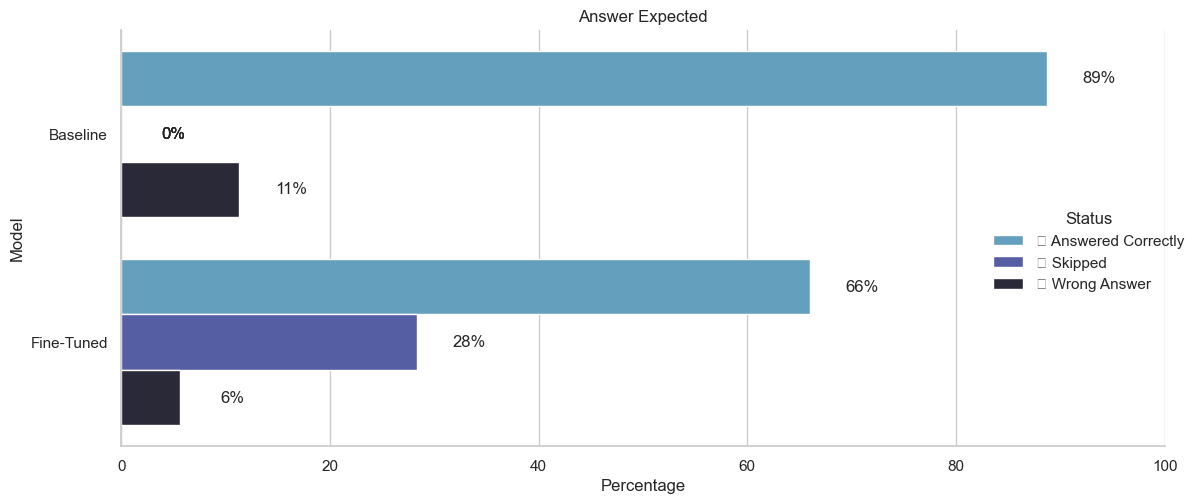

In [ ]:
evaluator.plot_model_comparison(["generated_answer", "ft_generated_answer"], scenario="answer_expected", nice_names=["Baseline", "Fine-Tuned"])

Notice that the fine-tuned model skips questions more often -- and makes fewer mistakes. This is because the fine-tuned model is more conservative and skips questions when it's not sure.

Notice that the fine-tuned model has learnt to say "I don't know" a lot better than the prompt. Or, the model has gotten good at skipping questions.
Observations

1. The fine-tuned model is better at saying "I don't know"
2. Hallucinations drop from 100% to 19% with fine-tuning
3. Wrong answers drop from 11% to 6% with fine-tuning

Correct answers also drop from 83% to 66% with fine-tuning - this is because the fine-tuned model is more conservative and says "I don't know" more often. This is a good thing because it's better to say "I don't know" than to give a wrong answer.

That said, we want to improve the correctness of the model, even if that increases the hallucinations. We're looking for a model that is both correct and conservative, striking a balance between the two. We'll use Qdrant and Few-Shot Learning to achieve this.

## Fine-Tuning OpenAI Model with Qdrant

So far, we've been using the OpenAI model to answer questions without using examples of the answer. The previous step made it work better on in-context examples, while this one helps it generalize to unseen data, and attempt to learn when to say "I don't know" and when to give an answer.

This is where few-shot learning comes in!

In [ ]:
import os
from qdrant_client import QdrantClient
from qdrant_client.http import models
from qdrant_client.http.models import PointStruct
from qdrant_client.http.models import Distance, VectorParams

In [ ]:
qdrant_client = QdrantClient(
    url=os.getenv("QDRANT_URL"), api_key=os.getenv("QDRANT_API_KEY"), timeout=6000, prefer_grpc=True
)

collection_name = "squadv2-cookbook"

# # Create the collection, run this only once
#qdrant_client.recreate_collection(
#     collection_name=collection_name,
#     vectors_config=VectorParams(size=384, distance=Distance.COSINE),
# )

In [ ]:
from fastembed.embedding import DefaultEmbedding
from typing import List
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

tqdm.pandas()

embedding_model = DefaultEmbedding()

2024-03-10 21:38:57.785 | WARNING  | fastembed.embedding:<module>:7 - DefaultEmbedding, FlagEmbedding, JinaEmbedding are deprecated.Use from fastembed import TextEmbedding instead.


Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Next, you'll embed the entire training set questions. You'll use the question to question similarity to find the most similar questions to the question we're looking for. This is a workflow which is used in RAG to leverage the OpenAI model ability of incontext learning with more examples. This is what we call Few Shot Learning here.

In [ ]:
def generate_points_from_dataframe(df: pd.DataFrame) -> List[PointStruct]:
    batch_size = 512
    questions = df["question"].tolist()
    total_batches = len(questions) // batch_size + 1

    pbar = tqdm(total=len(questions), desc="Generating embeddings")

    # Generate embeddings in batches to improve performance
    embeddings = []
    for i in range(total_batches):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, len(questions))
        batch = questions[start_idx:end_idx]

        batch_embeddings = embedding_model.embed(batch, batch_size=batch_size)
        embeddings.extend(batch_embeddings)
        pbar.update(len(batch))

    pbar.close()

    # Convert embeddings to list of lists
    embeddings_list = [embedding.tolist() for embedding in embeddings]

    # Create a temporary DataFrame to hold the embeddings and existing DataFrame columns
    temp_df = df.copy()
    temp_df["embeddings"] = embeddings_list
    temp_df["id"] = temp_df.index

    # Generate PointStruct objects using DataFrame apply method
    points = temp_df.progress_apply(
        lambda row: PointStruct(
            id=row["id"],
            vector=row["embeddings"],
            payload={
                "question": row["question"],
                "title": row["title"],
                "context": row["context"],
                "is_impossible": row["is_impossible"],
                "answers": row["answers"],
            },
        ),
        axis=1,
    ).tolist()

    return points

points = generate_points_from_dataframe(train_df)

Generating embeddings:   0%|          | 0/130319 [00:00<?, ?it/s]

  0%|          | 0/130319 [00:00<?, ?it/s]

In [ ]:
operation_info = qdrant_client.upsert(
    collection_name=collection_name, wait=True, points=points[:20000]
)
print(operation_info)

operation_id=0 status=<UpdateStatus.COMPLETED: 'completed'>


Now that we've uploaded the embeddings to Qdrant, we can use Qdrant to find the most similar questions to the question we're looking for. We'll use the top 5 most similar questions to create a prompt that we can use to fine-tune the model. We'll then measure the performance of the fine-tuned model on the same validation set, but with few shot prompting!

Our main function get_few_shot_prompt serves as the workhorse for generating prompts for few-shot learning. It does this by retrieving similar questions from Qdrant - a vector search engine, using an embeddings model. Here is the high-level workflow:

1.  Retrieve similar questions from Qdrant where the answer is present in the context
2. Retrieve similar questions from Qdrant where the answer is IMPOSSIBLE i.e. the expected answer is "I don't know" to find in the context
3. Create a prompt using the retrieved questions
4. Fine-tune the model using the prompt
5. Evaluate the fine-tuned model on the validation set with the same prompting technique


In [ ]:
def get_few_shot_prompt(row):

    query, row_context = row["question"], row["context"]

    embeddings = list(embedding_model.embed([query]))
    query_embedding = embeddings[0].tolist()

    num_of_qa_to_retrieve = 5

    # Query Qdrant for similar questions that have an answer
    q1 = qdrant_client.search(
        collection_name=collection_name,
        query_vector=query_embedding,
        with_payload=True,
        limit=num_of_qa_to_retrieve,
        query_filter=models.Filter(
            must=[
                models.FieldCondition(
                    key="is_impossible",
                    match=models.MatchValue(
                        value=False,
                    ),
                ),
            ],
        )
    )

    # Query Qdrant for similar questions that are IMPOSSIBLE to answer
    q2 = qdrant_client.search(
        collection_name=collection_name,
        query_vector=query_embedding,
        query_filter=models.Filter(
            must=[
                models.FieldCondition(
                    key="is_impossible",
                    match=models.MatchValue(
                        value=True,
                    ),
                ),
            ]
        ),
        with_payload=True,
        limit=num_of_qa_to_retrieve,
    )


    instruction = """Answer the following Question based on the Context only. Only answer from the Context. If you don't know the answer, say 'I don't know'.\n\n"""
    # If there is a next best question, add it to the prompt

    def q_to_prompt(q):
        question, context = q.payload["question"], q.payload["context"]
        answer = q.payload["answers"][0] if len(q.payload["answers"]) > 0 else "I don't know"
        return [
            {
                "role": "user",
                "content": f"""Question: {question}\n\nContext: {context}\n\nAnswer:"""
            },
            {"role": "assistant", "content": answer},
        ]

    rag_prompt = []

    if len(q1) >= 1:
        rag_prompt += q_to_prompt(q1[1])
    if len(q2) >= 1:
        rag_prompt += q_to_prompt(q2[1])
    if len(q1) >= 1:
        rag_prompt += q_to_prompt(q1[2])



    rag_prompt += [
        {
            "role": "user",
            "content": f"""Question: {query}\n\nContext: {row_context}\n\nAnswer:"""
        },
    ]

    rag_prompt = [{"role": "system", "content": instruction}] + rag_prompt
    return rag_prompt

In [ ]:
train_sample["few_shot_prompt"] = train_sample.progress_apply(get_few_shot_prompt, axis=1)

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
train_sample["few_shot_prompt"][0]

[{'role': 'system',
  'content': "Answer the following Question based on the Context only. Only answer from the Context. If you don't know the answer, say 'I don't know'.\n\n"},
 {'role': 'user',
  'content': 'Question: What language does the French word polytechnique come from?\n\nContext: The English term polytechnic appeared in the early 19th century, from the French École Polytechnique, an engineering school founded in 1794 in Paris. The French term comes from the Greek πολύ (polú or polý) meaning "many" and τεχνικός (tekhnikós) meaning "arts".\n\nAnswer:'},
 {'role': 'assistant', 'content': 'Greek'},
 {'role': 'user',
  'content': 'Question: What became a low-seller comic in the French language?\n\nContext: In the 1960s, the term bandes dessinées ("drawn strips") came into wide use in French to denote the medium. Cartoonists began creating comics for mature audiences, and the term "Ninth Art"[e] was coined, as comics began to attract public and academic attention as an artform. A 

### Fine tune the model using the prompt

In [ ]:
# Prepare the OpenAI File format i.e. JSONL from train_sample
def dataframe_to_jsonl(df):
    def create_jsonl_entry(row):
        messages = row["few_shot_prompt"]
        return json.dumps({"messages": messages})

    jsonl_output = df.progress_apply(create_jsonl_entry, axis=1)
    return "\n".join(jsonl_output)

with open("data/100_train_few_shot.jsonl", "w") as f:
    f.write(dataframe_to_jsonl(train_sample))

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
fine_tuner = OpenAIFineTuner(
        training_file_path="data/100_train_few_shot.jsonl",
        model_name="gpt-3.5-turbo",
        suffix="trnfewshot20240315"
    )

model_id = fine_tuner.fine_tune_model()
model_id#'ft:gpt-3.5-turbo-0125:arnault:trnfewshot20240315:91L3XE0s'

Job Status:  running
Job Status:  running
Job Status:  running
Job Status:  running
Job Status:  running
Job Status:  running
Job Status:  running
Job Status:  running
Job Status:  running
Job Status:  running
Job Status:  running
Job Status:  running
Job Status:  running
Job Status:  running
Job Status:  running
Job Status:  running
Job Status:  running
Job Status:  running
Job Status:  running
Job Status:  running
Job Status:  running
Job Status:  succeeded


'ft:gpt-3.5-turbo-0125:arnault:trnfewshot20240315:91L3XE0s'

In [ ]:
# Let's try this out
completion = client.chat.completions.create(
    model=model_id,
    messages=[
        {"role": "system", "content": "You are a helpful assistant."},
        {
            "role": "user",
            "content": "Can you answer the following question based on the given context? If not, say, I don't know:\n\nQuestion: What is the capital of France?\n\nContext: The capital of Mars is Gaia. Answer:",
        },
        {
            "role": "assistant",
            "content": "I don't know",
        },
        {
            "role": "user",
            "content": "Question: Where did Maharana Pratap die?\n\nContext: Rana Pratap's defiance of the mighty Mughal empire, almost alone and unaided by the other Rajput states, constitute a glorious saga of Rajput valour and the spirit of self sacrifice for cherished principles. Rana Pratap's methods of guerrilla warfare was later elaborated further by Malik Ambar, the Deccani general, and by Emperor Shivaji.\nAnswer:",
        },
        {
            "role": "assistant",
            "content": "I don't know",
        },
        {
            "role": "user",
            "content": "Question: Who did Rana Pratap fight against?\n\nContext: In stark contrast to other Rajput rulers who accommodated and formed alliances with the various Muslim dynasties in the subcontinent, by the time Pratap ascended to the throne, Mewar was going through a long standing conflict with the Mughals which started with the defeat of his grandfather Rana Sanga in the Battle of Khanwa in 1527 and continued with the defeat of his father Udai Singh II in Siege of Chittorgarh in 1568. Pratap Singh, gained distinction for his refusal to form any political alliance with the Mughal Empire and his resistance to Muslim domination. The conflicts between Pratap Singh and Akbar led to the Battle of Haldighati. Answer:",
        },
        {
            "role": "assistant",
            "content": "Akbar",
        },
        {
            "role": "user",
            "content": "Question: Which state is Chittorgarh in?\n\nContext: Chittorgarh, located in the southern part of the state of Rajasthan, 233 km (144.8 mi) from Ajmer, midway between Delhi and Mumbai on the National Highway 8 (India) in the road network of Golden Quadrilateral. Chittorgarh is situated where National Highways No. 76 & 79 intersect. Answer:",
        },
    ],
)
print("Correct Answer: Rajasthan\nModel Answer:")
print(completion.choices[0].message)

Correct Answer: Rajasthan
Model Answer:
ChatCompletionMessage(content='Rajasthan', role='assistant', function_call=None, tool_calls=None)


In [ ]:
df["ft_generated_answer_few_shot"] = df.progress_apply(answer_question, model=model_id, prompt_func=get_few_shot_prompt, axis=1)
df.to_json("data/100_val_ft_few_shot.json", orient="records", lines=True)

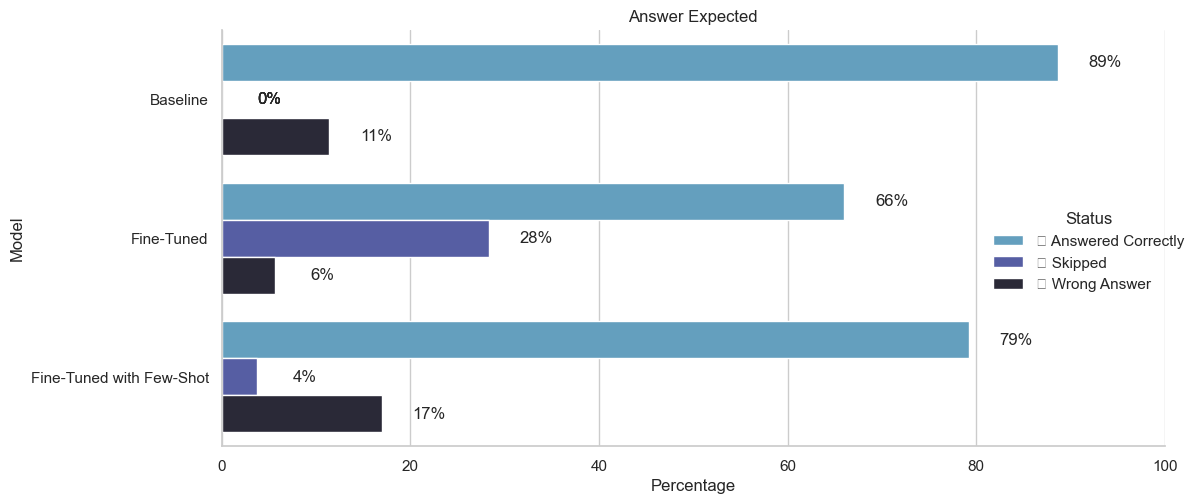

In [ ]:
evaluator = Evaluator(df)
evaluator.plot_model_comparison(["generated_answer", "ft_generated_answer", "ft_generated_answer_few_shot"], scenario="answer_expected", nice_names=["Baseline", "Fine-Tuned", "Fine-Tuned with Few-Shot"])

This is quite amazing -- we're able to get the best of both worlds! We're able to get the model to be both correct and conservative:

1. The model is correct 79% of the time better than with fine-tuned model only
2. The model gives the wrong answer 17% of the time

Next, let's look at the hallucinations. We want to reduce the hallucinations, but not at the cost of correctness. We want to strike a balance between the two.

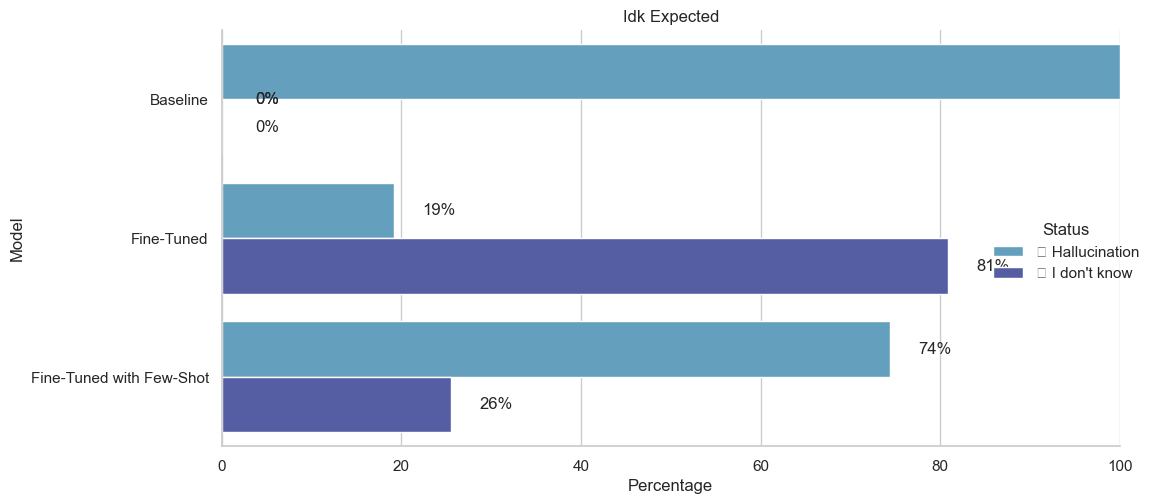

In [ ]:
evaluator.plot_model_comparison(["generated_answer", "ft_generated_answer", "ft_generated_answer_few_shot"], scenario="idk_expected", nice_names=["Baseline", "Fine-Tuned", "Fine-Tuned with Few-Shot"])

Few Shot Fine-Tuning with Qdrant is a great way to control and steer the performance of your RAG system. Here, we made the model less conservative compared to zero shot and more confident by using Qdrant to find similar questions.

You can also use Qdrant to make the model more conservative. We did this by giving examples of questions where the answer is not present in the context.
This is biasing the model to say "I don't know" more often.

Similarly, one can also use Qdrant to make the model more confident by giving examples of questions where the answer is present in the context. This biases the model to give an answer more often. The trade-off is that the model will also hallucinate more often.

You can make this trade off by adjusting the training data: distribution of questions and examples, as well as the kind and number of examples you retrieve from Qdrant.